In [33]:
import pandas as pd
# Load all raw CSV files into DataFrames
events = pd.read_csv("events.csv")
users = pd.read_csv("users.csv")
content = pd.read_csv("content.csv")
subs = pd.read_csv("subscriptions.csv")

# Preview the first rows of the events dataset
events.head()


,event_id,user_id,event_timestamp,event_type,content_id,session_id
0,1,1112,2024-05-20 19:09:00,complete_video,107.0,5578
1,2,2359,2024-07-16 02:35:00,return_app,NaN,6388
2,3,2738,2024-02-12 04:48:00,return_app,NaN,207
3,4,948,2024-05-27 03:21:00,onboarding_complete,NaN,6862
4,5,1999,2024-02-16 03:53:00,return_app,NaN,7980


## Data Cleaning & Feature Engineering

In this section, we prepare the raw datasets for analysis by:

- Converting date and time columns to proper datetime format
- Creating new time-based features (event date & event hour)
- Merging user signup information into the events table
- Calculating the number of days since signup for each event
- Sorting events chronologically by user

These steps ensure the dataset is fully structured for funnel analysis, retention analysis, and segmentation.

In [34]:
# Convert the event timestamp column to datetime format for time-based analysis
events["event_timestamp"] = pd.to_datetime(events["event_timestamp"])

# Convert the user signup date column to datetime format for consistency
users["signup_datetime"] = pd.to_datetime(users["signup_datetime"])


In [35]:
# Extract the date (YYYY-MM-DD) from the full event timestamp
events["event_date"] = events["event_timestamp"].dt.date

# Extract the hour (0–23) from the event timestamp
events["event_hour"] = events["event_timestamp"].dt.hour


In [36]:
# Merge user signup date into the events dataset for time-based user analysis
events = events.merge(
    users[["user_id", "signup_datetime"]],  # Select only needed columns from users table
    on="user_id",                            # Join on user ID
    how="left"                              # Keep all event records
)


In [37]:
# Calculate the number of days between the event and the user's signup date
events["day_since_signup"] = (events["event_timestamp"] - events["signup_datetime"]).dt.days


In [38]:
# Sort events by user ID and event time to ensure correct chronological order
events = events.sort_values(["user_id", "event_timestamp"]).reset_index(drop=True)  # Reset index after sorting for clean sequential indexing


In [39]:
events.head()


,event_id,user_id,event_timestamp,event_type,content_id,session_id,event_date,event_hour,signup_datetime,day_since_signup
0,3943,1,2024-04-13 12:24:00,signup,NaN,5864,2024-04-13,12,2024-04-12,1
1,12766,1,2024-04-20 15:28:00,play_video,23.0,3828,2024-04-20,15,2024-04-12,8
2,4120,1,2024-04-21 09:50:00,play_video,220.0,3939,2024-04-21,9,2024-04-12,9
3,30048,1,2024-04-22 01:24:00,play_video,120.0,339,2024-04-22,1,2024-04-12,10
4,13929,1,2024-04-25 14:59:00,return_app,NaN,6016,2024-04-25,14,2024-04-12,13


## Exploratory Funnel Analysis

We calculate:
- The number of unique users at each funnel stage
- The conversion rate between consecutive steps
This gives an initial view of user drop-off before enforcing sequential funnel logic.


In [40]:
# Count how many unique users completed each funnel step (unforced funnel)
funnel_counts = (
    events[events["event_type"].isin([     # Keep only events related to the funnel
        "signup",
        "onboarding_complete",
        "play_video",
        "return_app",
        "subscribe"
    ])]
    .groupby("event_type")["user_id"]      # Group by funnel step and select user IDs
    .nunique()                             # Count unique users per step
    .reindex([                             # Reorder steps to match the funnel flow
        "signup",
        "onboarding_complete",
        "play_video",
        "return_app",
        "subscribe"
    ])
)
# Display the unforced funnel user counts
funnel_counts


event_type
signup                 2481
onboarding_complete    2064
play_video             2924
return_app             2615
subscribe               611
Name: user_id, dtype: int64

In [41]:
# Convert the funnel counts Series into a DataFrame
funnel_df = funnel_counts.to_frame(name="users")

# Calculate the conversion rate from the previous funnel step
funnel_df["conversion_from_previous"] = (
    funnel_df["users"] / funnel_df["users"].shift(1)
)

# Display the funnel DataFrame with user counts and conversion rates
funnel_df


,users,conversion_from_previous
event_type,,
signup,2481,NaN
onboarding_complete,2064,0.831923
play_video,2924,1.416667
return_app,2615,0.894323
subscribe,611,0.233652


In [42]:
funnel_counts


event_type
signup                 2481
onboarding_complete    2064
play_video             2924
return_app             2615
subscribe               611
Name: user_id, dtype: int64

In [43]:
# Display the final funnel table with user counts and conversion rates
funnel_df


,users,conversion_from_previous
event_type,,
signup,2481,NaN
onboarding_complete,2064,0.831923
play_video,2924,1.416667
return_app,2615,0.894323
subscribe,611,0.233652


## Preparing Data for Forced & A/B Funnel Analysis

This section defines the funnel steps and restructures the data into a user-level format required for the forced funnel and A/B analysis.


In [44]:
# Define the ordered sequence of events that make up the funnel
steps = [
    "signup",
    "onboarding_complete",
    "play_video",
    "return_app",
    "subscribe"
]


In [45]:
# Create a user-level matrix showing whether each user completed each funnel step
user_events = (
    events[events["event_type"].isin(steps)]                              # Keep only events that are part of the funnel
    .drop_duplicates(subset=["user_id", "event_type"])                     # Remove duplicate user-step combinations
    .pivot(index="user_id", columns="event_type", values="event_type")    # Reshape data to user-level format
    .notnull()                                                             # Rows = individual users
                                                                           # Columns = funnel steps
                                                                           # Convert values to True/False (completed or not)
)
# Display the user-level funnel completion matrix
user_events


event_type,onboarding_complete,play_video,return_app,signup,subscribe
user_id,,,,,
1,False,True,True,True,True
2,True,True,True,True,False
3,False,True,False,True,False
4,True,True,True,False,False
5,True,True,True,False,False
...,...,...,...,...,...
2996,False,True,True,True,True
2997,False,True,True,True,False
2998,True,True,False,True,True


## Forced Funnel (All Users)

This section computes the forced funnel where users must complete each step in order to be counted.


In [46]:
# Initialize a dictionary to store forced funnel user counts
forced_counts = {}

# Start with users who completed the first funnel step (signup)
current_users = user_events["signup"]

# Loop through each funnel step in order
for step in steps:
    # Keep only users who have completed all previous steps AND the current step
    current_users = current_users & user_events[step]
    # Store the number of users who reached this step sequentially
    forced_counts[step] = current_users.sum()
    
# Display the forced funnel user counts
forced_counts


{'signup': np.int64(2481),
 'onboarding_complete': np.int64(1719),
 'play_video': np.int64(1683),
 'return_app': np.int64(1463),
 'subscribe': np.int64(287)}

In [47]:
import pandas as pd  # Import pandas for DataFrame creation and manipulation

# Convert the forced funnel user counts dictionary into a DataFrame
forced_funnel = pd.DataFrame.from_dict(
    forced_counts, orient="index", columns=["users"]  # Dictionary with forced funnel user counts
)                                                     # Use dictionary keys as row index (funnel steps)
                                                      # Name the user count column

# Calculate the conversion rate from the previous funnel step
forced_funnel["conversion_from_previous"] = (
    forced_funnel["users"] / forced_funnel["users"].shift(1)
)
# Display the forced funnel DataFrame with user counts and conversion rates
forced_funnel


,users,conversion_from_previous
signup,2481,NaN
onboarding_complete,1719,0.692866
play_video,1683,0.979058
return_app,1463,0.869281
subscribe,287,0.196172


## Adding Experiment Variant to Users

Here we attach each user to their A/B test variant.


In [48]:
# Attach the A/B experiment variant (A or B) to each user in the user-level dataset
user_events = user_events.merge(
    users[["user_id", "experiment_variant"]],    # Select only the user ID and experiment group
    on="user_id",                                 # Merge using the user ID
    how="left"                                   # Keep all users from the funnel dataset
)


In [49]:
user_events.head()


,user_id,onboarding_complete,play_video,return_app,signup,subscribe,experiment_variant
0,1,False,True,True,True,True,B
1,2,True,True,True,True,False,B
2,3,False,True,False,True,False,B
3,4,True,True,True,False,False,B
4,5,True,True,True,False,False,B


In [50]:
def compute_forced_funnel(df, steps):
    # Initialize a dictionary to store forced funnel user counts
    forced = {}

    # Start with users who completed the first funnel step (e.g., signup)
    current = df[steps[0]].copy()
    
    # Loop through each funnel step in order
    for step in steps:
        # Keep only users who completed all previous steps AND the current step
        current = current & df[step]
        # Store the number of users who reached this step sequentially
        forced[step] = int(current.sum())

    # Return the forced funnel results as a dictionary
    return forced


## Forced Funnel Comparison: Variant A vs Variant B

This section compares the forced funnel results and conversion rates between experiment variants A and B.


In [51]:
# Compute the forced funnel for users in Variant A
funnel_A = compute_forced_funnel(
    user_events[user_events["experiment_variant"] == "A"],   # Filter users in group A
    steps                                                     # Use the predefined funnel steps
)

# Compute the forced funnel for users in Variant B
funnel_B = compute_forced_funnel(
    user_events[user_events["experiment_variant"] == "B"],     # Filter users in group B
    steps                                                       # Use the same funnel steps
)

# Display the forced funnel results for both variants
funnel_A, funnel_B


({'signup': 1215,
  'onboarding_complete': 836,
  'play_video': 820,
  'return_app': 714,
  'subscribe': 145},
 {'signup': 1266,
  'onboarding_complete': 883,
  'play_video': 863,
  'return_app': 749,
  'subscribe': 142})

In [52]:
# Convert Variant A forced funnel results into a DataFrame
df_A = pd.DataFrame.from_dict(funnel_A, orient="index", columns=["A_users"])

# Convert Variant B forced funnel results into a DataFrame
df_B = pd.DataFrame.from_dict(funnel_B, orient="index", columns=["B_users"])

# Combine both A and B funnel results into a single DataFrame
ab_funnel = pd.concat([df_A, df_B], axis=1)

# Conversion rates
ab_funnel["A_conv"] = ab_funnel["A_users"] / ab_funnel["A_users"].shift(1)
ab_funnel["B_conv"] = ab_funnel["B_users"] / ab_funnel["B_users"].shift(1)

ab_funnel


,A_users,B_users,A_conv,B_conv
signup,1215,1266,NaN,NaN
onboarding_complete,836,883,0.688066,0.697472
play_video,820,863,0.980861,0.977350
return_app,714,749,0.870732,0.867903
subscribe,145,142,0.203081,0.189586


In [29]:
ab_funnel


,A_users,B_users,A_conv,B_conv
signup,1215,1266,NaN,NaN
onboarding_complete,836,883,0.688066,0.697472
play_video,820,863,0.980861,0.977350
return_app,714,749,0.870732,0.867903
subscribe,145,142,0.203081,0.189586


## Forced Funnel Visualization (All Users)

This chart visualizes how users drop off across the full forced funnel.


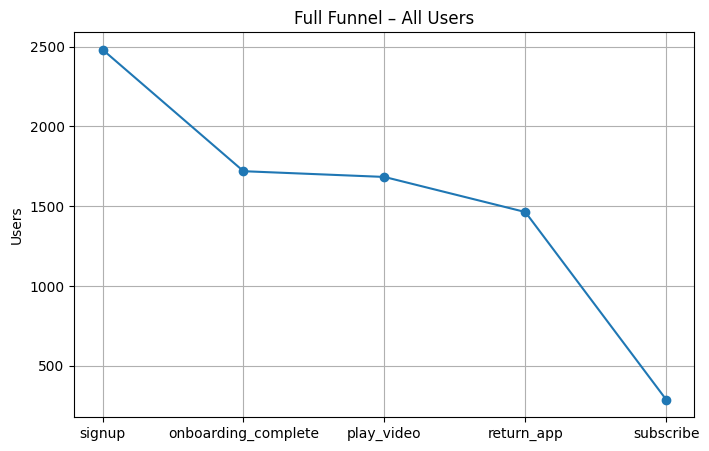

In [53]:
import matplotlib.pyplot as plt   # Import Matplotlib for data visualization


plt.figure(figsize=(8,5))         # Create a new figure with a specific size
# Plot the number of users at each forced funnel step
plt.plot(forced_funnel.index, forced_funnel["users"], marker="o")
plt.title("Full Funnel – All Users")
plt.ylabel("Users")
plt.grid(True)
plt.show()


In [21]:
!pip install matplotlib


In [22]:
import matplotlib.pyplot as plt


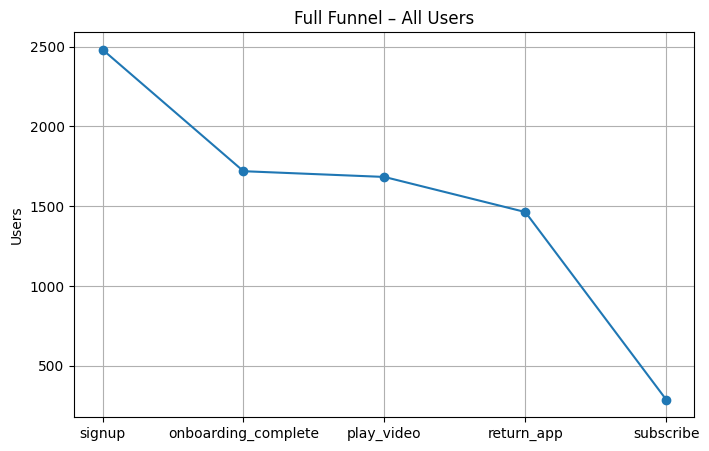

In [54]:
import matplotlib.pyplot as plt    # Import Matplotlib for plotting


plt.figure(figsize=(8,5))          # Create a new figure with a fixed size

# Plot the total number of users at each forced funnel step
plt.plot(forced_funnel.index, forced_funnel["users"], marker="o")
plt.title("Full Funnel – All Users")
plt.ylabel("Users")
plt.grid(True)
plt.show()


## A/B Conversion Rate Comparison

This chart compares conversion rates across funnel steps between Variant A and Variant B.


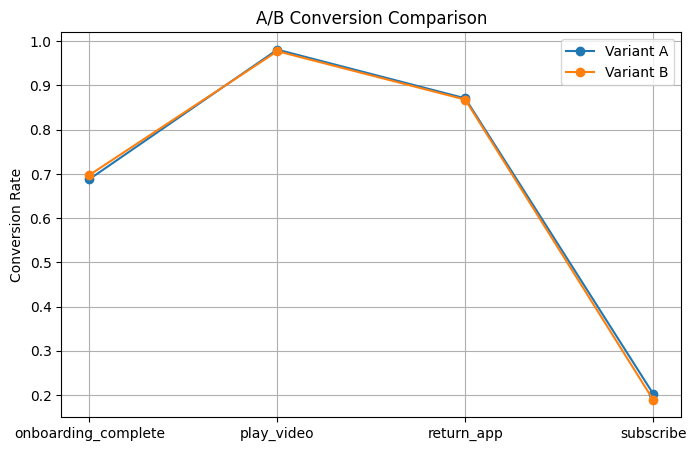

In [24]:
plt.figure(figsize=(8,5))     # Create a new figure with a fixed size
x = ab_funnel.index           # Store the funnel steps for the X-axis

# Plot conversion rates for Variant A
plt.plot(x, ab_funnel["A_conv"], marker="o", label="Variant A")

# Plot conversion rates for Variant B
plt.plot(x, ab_funnel["B_conv"], marker="o", label="Variant B")

plt.title("A/B Conversion Comparison")
plt.ylabel("Conversion Rate")
plt.legend()
plt.grid(True)
plt.show()


## Adding User Attributes for Segmentation

Here we enrich the user-level funnel data with device type, acquisition channel, country, plan, and experiment variant for advanced segmentation analysis.


In [55]:
# Enrich the user-level funnel dataset with additional user attributes for segmentation analysis
user_events = user_events.merge(
    users[["user_id", "device_type", "acquisition_channel", "country", "initial_plan", "experiment_variant"]],
    on="user_id",          # Select only relevant user attributes
    how="left"             # Merge using the user ID
                        # Keep all users from the funnel dataset
)


## Forced Funnel by User Segment

This function computes the forced funnel separately for each user segment (e.g., device type, country, or acquisition channel).


In [56]:
def forced_funnel_by_segment(segment_col):
    # Initialize a dictionary to store forced funnel results for each segment
    results = {}

    # Loop through each unique segment value (e.g., mobile, web, tablet)
    for segment_value in user_events[segment_col].dropna().unique():

        # Filter users belonging to the current segment
        segment_users = user_events[user_events[segment_col] == segment_value]

        # Start with users who completed the first funnel step (signup)
        current = segment_users["signup"]

        # List to store forced funnel user counts for this segment
        forced = []
        # Loop through each funnel step in order
        for step in steps:
            # Keep only users who completed all previous steps AND the current step
            current = current & segment_users[step]

            # Store the number of users who reached this step sequentially
            forced.append(current.sum())

            
        # Store the forced funnel results for this segment
        results[segment_value] = forced

    # Return the forced funnel results for all segments
    return results


## Forced Funnel by Device Type

This section shows how users progress through the forced funnel across different device types (mobile, tablet, and web), along with their step-by-step conversion rates.


In [32]:
## Forced Funnel by Device Type
forced_funnel_by_segment("device_type")


{'mobile': [np.int64(793),
  np.int64(537),
  np.int64(526),
  np.int64(452),
  np.int64(81)],
 'tablet': [np.int64(829),
  np.int64(577),
  np.int64(567),
  np.int64(490),
  np.int64(92)],
 'web': [np.int64(859),
  np.int64(605),
  np.int64(590),
  np.int64(521),
  np.int64(114)]}

In [57]:
# Define the ordered sequence of funnel steps
steps = ["signup", "onboarding_complete", "play_video", "return_app", "subscribe"]

# Compute the forced funnel separately for each device type
seg_results = forced_funnel_by_segment("device_type")

# Convert the segmented forced funnel results into a DataFrame
seg_funnel = pd.DataFrame(seg_results, index=steps)

# Display the segmented forced funnel table (user counts by device type)
seg_funnel


,mobile,tablet,web
signup,793,829,859
onboarding_complete,537,577,605
play_video,526,567,590
return_app,452,490,521
subscribe,81,92,114


In [58]:
# Calculate step-by-step conversion rates for each device type
seg_conv = seg_funnel.div(seg_funnel.shift(1))   # Divide each step by the previous step to get conversion rate

# Display the segmented conversion rate table
seg_conv


,mobile,tablet,web
signup,NaN,NaN,NaN
onboarding_complete,0.677175,0.696019,0.704307
play_video,0.979516,0.982669,0.975207
return_app,0.859316,0.864198,0.883051
subscribe,0.179204,0.187755,0.218810


In [59]:
# Compute the forced funnel separately for each device type
segment_results = forced_funnel_by_segment("device_type")

# Convert the segmented forced funnel results into a DataFrame
segment_funnel_df = pd.DataFrame(
    segment_results,                            # Dictionary with forced funnel results per device type
    index=steps  # signup → onboarding → ...
)

# Display the device-type segmented forced funnel table
segment_funnel_df


,mobile,tablet,web
signup,793,829,859
onboarding_complete,537,577,605
play_video,526,567,590
return_app,452,490,521
subscribe,81,92,114


## Device-Type Funnel Visualization

This chart compares how users move through the forced funnel across different device types.


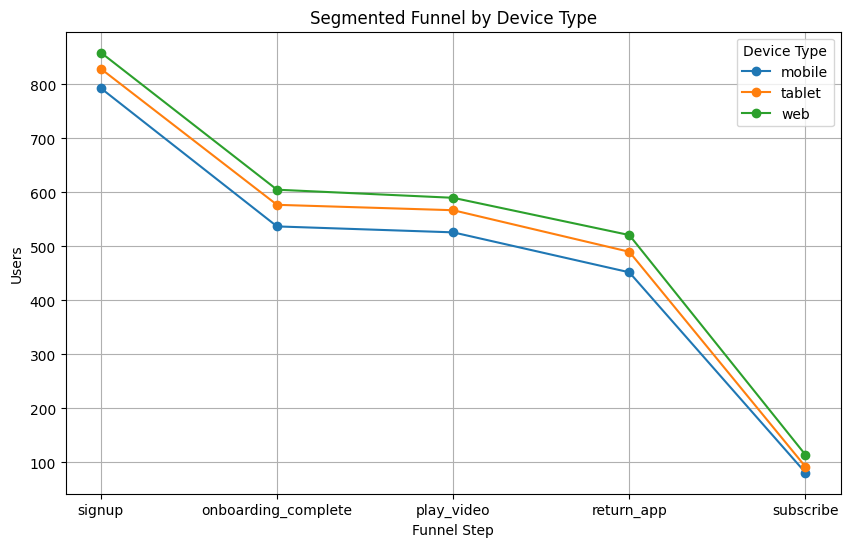

In [60]:
import matplotlib.pyplot as plt       # Import Matplotlib for data visualization

plt.figure(figsize=(10,6))            # Create a new figure with a larger size for clarity

# Loop through each device type (e.g., mobile, web, tablet)
for device in segment_funnel_df.columns:

    # Plot the number of users at each funnel step for the current device type
    plt.plot(segment_funnel_df.index, segment_funnel_df[device], marker="o", label=device)

plt.title("Segmented Funnel by Device Type")      # Set the chart title
plt.ylabel("Users")                               # Label the Y-axis
plt.xlabel("Funnel Step")                         # Label the X-axis
plt.legend(title="Device Type")                   # Display the legend with a title
plt.grid(True)                                    # Add a background grid for readability
plt.show()                                        # Render and display the chart


## Device-Type Conversion Rate Visualization

This chart compares the step-by-step conversion rates across different device types.


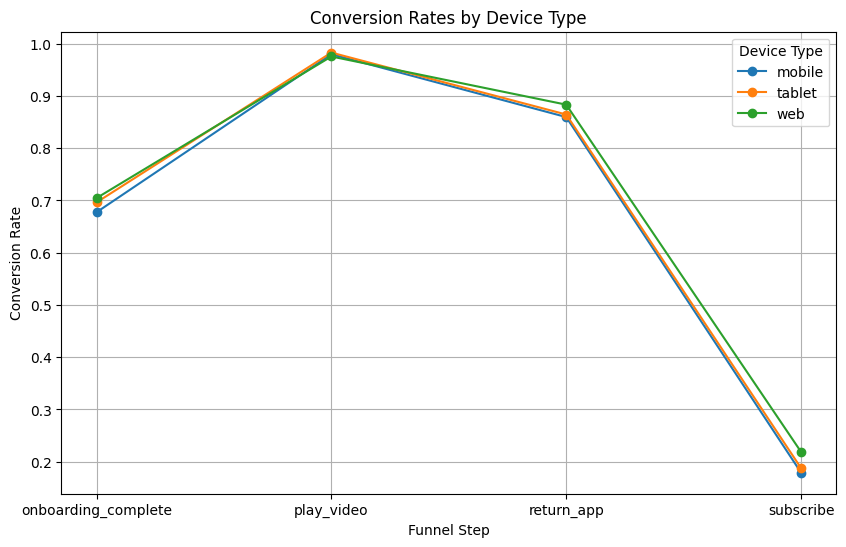

In [61]:
# Calculate step-by-step conversion rates for each device type
segment_conv = segment_funnel_df.div(segment_funnel_df.shift(1))   # Divide each step by the previous step to get conversion rates

plt.figure(figsize=(10,6))        # Create a new figure with a larger size for better visibility

# Loop through each device type (e.g., mobile, web, tablet)
for device in segment_conv.columns:
    # Plot conversion rates for each device type, starting from the second step
    plt.plot(segment_conv.index[1:], segment_conv[device][1:], marker="o", label=device)

plt.title("Conversion Rates by Device Type")       # Set the chart title
plt.ylabel("Conversion Rate")                      # Label the Y-axis
plt.xlabel("Funnel Step")                          # Label the X-axis
plt.legend(title="Device Type")                    # Display the legend with a title
plt.grid(True)                                     # Add a background grid for readability
plt.show()                                         # Render and display the chart
